In [3]:
import sys
sys.path.append('../fair_regression')

import h5py
import torch
from torch.autograd import Variable

from FairLogReg import FairLogisticRegression
from DataPreprocessing import get_adult_data


def train_split(x, y, pct):
    nsamples = len(y)
    nsamples_val = int(pct * nsamples)
    srs = torch.utils.data.sampler.SubsetRandomSampler(range(nsamples))
    idxs = []
    for n, i in enumerate(srs):
        idxs.append(i)
        if n == nsamples_val - 1:
            x_val = x[idxs]
            y_val = y[idxs]
            idxs = []
    x = x[idxs]
    y = y[idxs]

    return x, y, x_val, y_val

In [6]:
# Import data as pandas dataframes
s_id = ['Sex_Female']
s, x_train, y_train, x_test, y_test = get_adult_data(s_id)

# # Save the header info before turning into matrices
# x_cols = x_train.columns
# y_cols = y_train.columns

# Convert the dataframes into PyTorch variables and cuda-fy if available
x_train = Variable(torch.from_numpy(x_train.as_matrix()))
y_train = Variable(torch.from_numpy(y_train.as_matrix()).long())
x_test = Variable(torch.from_numpy(x_test.as_matrix()))

if torch.cuda.is_available():
    x_train = x_train.cuda()
    y_train = y_train.cuda()
    x_test = x_test.cuda()

# We'll only compare y_test as a numpy array, so don't bother to convert
y_test = y_test.as_matrix()

In [7]:
flr = FairLogisticRegression(l_fair=0.06, validate=0.2, print_freq=1, ftol=1e-7,
                             penalty_type='individual', minibatch_size=512,
                             batch_fairness=True, n_epochs=256)

In [9]:
flr.fit(x_train, y_train, s)

Epoch [1/256] Training    CE Loss: 0.43556   Accuracy: 0.80341   Penalty: 0.64862
              Validation  CE Loss: 0.45542   Accuracy: 0.80467   Penalty: 0.76008
Epoch [2/256] Training    CE Loss: 0.42876   Accuracy: 0.8026   Penalty: 0.59651
              Validation  CE Loss: 0.44821   Accuracy: 0.80421   Penalty: 0.72125
Epoch [3/256] Training    CE Loss: 0.42753   Accuracy: 0.80437   Penalty: 0.61747
              Validation  CE Loss: 0.44672   Accuracy: 0.80743   Penalty: 0.74895
Epoch [4/256] Training    CE Loss: 0.42744   Accuracy: 0.80537   Penalty: 0.62724
              Validation  CE Loss: 0.44627   Accuracy: 0.80805   Penalty: 0.76348
Epoch [5/256] Training    CE Loss: 0.4275   Accuracy: 0.80544   Penalty: 0.63122
              Validation  CE Loss: 0.4461   Accuracy: 0.80881   Penalty: 0.77033
Epoch [6/256] Training    CE Loss: 0.42758   Accuracy: 0.80556   Penalty: 0.63321
              Validation  CE Loss: 0.44603   Accuracy: 0.80912   Penalty: 0.77413
Epoch [7/256] Train

Epoch [51/256] Training    CE Loss: 0.4287   Accuracy: 0.80924   Penalty: 0.65221
              Validation  CE Loss: 0.44621   Accuracy: 0.81496   Penalty: 0.79956
Epoch [52/256] Training    CE Loss: 0.4287   Accuracy: 0.80928   Penalty: 0.65227
              Validation  CE Loss: 0.44621   Accuracy: 0.81496   Penalty: 0.79965
Epoch [53/256] Training    CE Loss: 0.42871   Accuracy: 0.80928   Penalty: 0.65233
              Validation  CE Loss: 0.44622   Accuracy: 0.81496   Penalty: 0.79973
Epoch [54/256] Training    CE Loss: 0.42872   Accuracy: 0.80932   Penalty: 0.65238
              Validation  CE Loss: 0.44622   Accuracy: 0.81496   Penalty: 0.7998
Epoch [55/256] Training    CE Loss: 0.42872   Accuracy: 0.80932   Penalty: 0.65243
              Validation  CE Loss: 0.44622   Accuracy: 0.81496   Penalty: 0.79987
Epoch [56/256] Training    CE Loss: 0.42873   Accuracy: 0.80932   Penalty: 0.65248
              Validation  CE Loss: 0.44622   Accuracy: 0.81511   Penalty: 0.79994
Epoch [57/256

Epoch [101/256] Training    CE Loss: 0.42881   Accuracy: 0.80951   Penalty: 0.65314
              Validation  CE Loss: 0.44625   Accuracy: 0.81465   Penalty: 0.80093
Epoch [102/256] Training    CE Loss: 0.42881   Accuracy: 0.80951   Penalty: 0.65314
              Validation  CE Loss: 0.44625   Accuracy: 0.81465   Penalty: 0.80093
Epoch [103/256] Training    CE Loss: 0.42881   Accuracy: 0.80951   Penalty: 0.65314
              Validation  CE Loss: 0.44625   Accuracy: 0.81465   Penalty: 0.80093
Epoch [104/256] Training    CE Loss: 0.42881   Accuracy: 0.80951   Penalty: 0.65315
              Validation  CE Loss: 0.44625   Accuracy: 0.81465   Penalty: 0.80094


In [16]:
y_pred = flr.predict(x_test).data.cpu().numpy()
y_probas = torch.nn.Softmax(dim=1)(flr.model.forward(x_test)).data.cpu().numpy()

In [18]:
from sklearn.metrics import roc_auc_score, mean_squared_error
mean_squared_error(y_test, y_pred)

0.1888704625023033

In [31]:
roc_auc_score(y_test, y_probas[:, 1])

0.8889499552639926

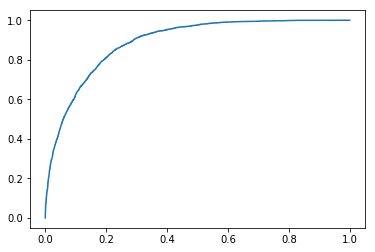

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

curve = roc_curve(y_test, y_probas[:, 1])

plt.plot(*curve[:2])

In [75]:
import torch
from torch.autograd import Variable

class converting_FairLogReg(object):
    def __init__(self, **kwargs):
        self.params = kwargs.copy()
        self.s = kwargs['s']
        del kwargs['s']

        self.flr = FairLogisticRegression(**kwargs)
    
    def get_params(self, deep=False):
        return self.params.copy()
    
    def set_params(self, **kwargs):
        if 's' in kwargs:
            self.s = kwargs['s']
        if 'lr' in kwargs:
            self.flr.lr = kwargs['lr']
        if 'n_classes' in kwargs:
            self.flr.n_classes = kwargs['n_classes']
        if 'ftol' in kwargs:
            self.flr.ftol = kwargs['ftol']
        if 'tolerance_grad' in kwargs:
            self.flr.tolerance_grad = kwargs['tolerance_grad']
        if 'fit_intercept' in kwargs:
            self.flr.fit_intercept = kwargs['fit_intercept']
        if 'n_epochs' in kwargs:
            self.flr.n_epochs = kwargs['n_epochs']
        if 'l_fair' in kwargs:
            self.flr.l_fair = float(kwargs['l_fair'])
        if 'l1' in kwargs:
            self.flr.l1 = float(kwargs['l1'])
        if 'l2' in kwargs:
            self.flr.l2 = float(kwargs['l2'])
        if 'minibatch_size' in kwargs:
            self.flr.minibatch_size = kwargs['minibatch_size']
        if 'njobs' in kwargs:
            self.flr.njobs = kwargs['njobs']
        if 'validate' in kwargs:
            self.flr.validate = kwargs['validate']
        if 'print_freq' in kwargs:
            self.flr.verbose = kwargs['print_freq']
        if 'penalty_type' in kwargs:
            self.flr.penalty_type = kwargs['penalty_type']
        if 'batch_fairness' in kwargs:
            self.flr.mb_fairness = kwargs['batch_fairness']
        return self
        
    
    @staticmethod
    def convert_to_torch(x, y):
        x = Variable(torch.from_numpy(x))
        y = Variable(torch.from_numpy(y).long())
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()

        return x, y

#     @staticmethod
#     def convert_from_torch(self, x, y):
#         pass
    
    def fit(self, x, y):
        x, y = self.convert_to_torch(x, y)
        self.flr.fit(x, y, self.s)
    
    def score(self, x, y):
        x, y = self.convert_to_torch(x, y)
        return self.flr.score(x, y)

In [76]:
from sklearn.model_selection import GridSearchCV

# self, lr=0.01, n_classes=None, ftol=1e-6, tolerance_grad=1e-5,
#                  fit_intercept=True, n_epochs=32, l_fair=0.0, l1=0.0, l2=0.0,
#                  minibatch_size=32, n_jobs=1, validate=0, print_freq=0,
#                  penalty_type='individual', batch_fairness=False

ls = np.logspace(-10, 2, 13)
indiv = converting_FairLogReg(s=s, n_epochs=256, minibatch_size=512, batch_fairness=True, penalty_type='individual')
group = converting_FairLogReg(s=s, n_epochs=256, minibatch_size=512, batch_fairness=True, penalty_type='group')

individual_cv = GridSearchCV(indiv, {'l2': ls, 'l_fair': ls}, cv=3)
group_cv = GridSearchCV(group, {'l2': ls, 'l_fair': ls}, cv=3)

In [77]:
individual_cv.fit(x_train.data.cpu().numpy(), y_train.data.cpu().numpy())

Automatic pdb calling has been turned OFF


GridSearchCV(cv=3, error_score='raise',
       estimator=<__main__.converting_FairLogReg object at 0x12895e4a8>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'l2': array([1.e-10, 1.e+02]), 'l_fair': array([1.e-10, 1.e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [78]:
individual_cv.best_params_

{'l2': 1e-10, 'l_fair': 1e-10}

In [79]:
individual_cv.cv_results_

/Users/austin/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/austin/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/austin/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/austin/anaconda3/lib/py

{'mean_fit_time': array([145.02807665, 146.73348037,  99.83858387, 132.64187757]),
 'mean_score_time': array([0.00258136, 0.00333436, 0.00328048, 0.00363008]),
 'mean_test_score': array([0.84874544, 0.75919044, 0.79094621, 0.76591628]),
 'mean_train_score': array([0.84891436, 0.7591904 , 0.79113056, 0.76573201]),
 'param_l2': masked_array(data=[1e-10, 1e-10, 100.0, 100.0],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_l_fair': masked_array(data=[1e-10, 100.0, 1e-10, 100.0],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'l2': 1e-10, 'l_fair': 1e-10},
  {'l2': 1e-10, 'l_fair': 100.0},
  {'l2': 100.0, 'l_fair': 1e-10},
  {'l2': 100.0, 'l_fair': 100.0}],
 'rank_test_score': array([1, 4, 2, 3], dtype=int32),
 'split0_test_score': array([0.84586328, 0.76239175, 0.80477244, 0.77307904]),
 'split0_train_score': array([0.84995621, 0.7575897 , 0.80347353, 0.76772469]

In [80]:
individual_cv.grid_scores_

/Users/austin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.84875, std: 0.00210, params: {'l2': 1e-10, 'l_fair': 1e-10},
 mean: 0.75919, std: 0.00295, params: {'l2': 1e-10, 'l_fair': 100.0},
 mean: 0.79095, std: 0.00978, params: {'l2': 100.0, 'l_fair': 1e-10},
 mean: 0.76592, std: 0.00532, params: {'l2': 100.0, 'l_fair': 100.0}]

In [84]:
y_test

array([0, 0, 1, ..., 0, 0, 1], dtype=uint8)

In [93]:
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Import data as pandas dataframes
s_id = ['Sex_Female']
s, x_train, y_train, x_test, y_test = get_adult_data(s_id)

# # Save the header info before turning into matrices
x_cols = x_train.columns
# y_cols = y_train.columns

# Convert the dataframes into PyTorch variables and cuda-fy if available
x_train = Variable(torch.from_numpy(x_train.as_matrix()))
y_train = Variable(torch.from_numpy(y_train.as_matrix()).long())
x_test = Variable(torch.from_numpy(x_test.as_matrix()))
y_test = Variable(torch.from_numpy(y_test.as_matrix()).long())

if torch.cuda.is_available():
    x_train = x_train.cuda()
    y_train = y_train.cuda()
    x_test = x_test.cuda()
    y_test = y_test.cuda()

## K-fold Cross Validation for FairLogReg fairness search
shared_kwargs = {'ftol': 1e-6, 'n_epochs': 256, 'minibatch_size': 512, 'batch_fairness': True}

df_template = {'Type': [], 'MSE': [], 'Score': [], 'Group Penalty': [], 'Individual Penalty': [], 'ID_String': []}
penalties = np.logspace(-10, 2, 13)
cv = KFold(3)

models = {}
fold = 0
df = pd.DataFrame()

for train, test in cv.split(x_train, y_train):
    fold += 1
    for penalty in penalties:
        current_df_dict = df_template.copy()
        penalty = float(penalty)  # PyTorch messes up with numpy types

        # Define models
        plain = FairLogisticRegression(**shared_kwargs)
        indiv = FairLogisticRegression(l_fair=penalty, penalty_type='individual', **shared_kwargs)
        group = FairLogisticRegression(l_fair=penalty, penalty_type='group', **shared_kwargs)
        
        # Fit them
        plain.fit(x_train, y_train, s)
        indiv.fit(x_train, y_train, s)
        group.fit(x_train, y_train, s)
        
        # Save them
        plain_str = 'fold: {} pen: {} type: {}'.format(fold, penalty, 'plain')
        indiv_str = 'fold: {} pen: {} type: {}'.format(fold, penalty, 'indiv')
        group_str = 'fold: {} pen: {} type: {}'.format(fold, penalty, 'group')
        
        models[plain_str] = plain
        models[indiv_str] = indiv
        models[group_str] = group
        
        # Save string for identifying models
        current_df_dict['ID_String'].extend([plain_str, indiv_str, group_str])
        
        # Save score info
        plain_score = plain.score(x_test, y_test)
        indiv_score = indiv.score(x_test, y_test)
        group_score = group.score(x_test, y_test)
        current_df_dict['Score'].extend([plain_score, indiv_score, group_score])
        
        # Save MSE info
        plain_pred = plain.predict(x_test).data.cpu().numpy()
        indiv_pred = indiv.predict(x_test).data.cpu().numpy()
        group_pred = group.predict(x_test).data.cpu().numpy()

        plain_mse = mean_squared_error(plain_pred, y_test.data.cpu().numpy())
        indiv_mse = mean_squared_error(indiv_pred, y_test.data.cpu().numpy())
        group_mse = mean_squared_error(group_pred, y_test.data.cpu().numpy())

        current_df_dict['MSE'].extend([plain_mse, indiv_mse, group_mse])
        
        # Save Penalty info
        plain_pen_i = plain.fairness_penalty(x_test, y_test, x_test, y_test, s, penalty_type='individual')
        indiv_pen_i = indiv.fairness_penalty(x_test, y_test, x_test, y_test, s, penalty_type='individual')
        group_pen_i = group.fairness_penalty(x_test, y_test, x_test, y_test, s, penalty_type='individual')
        
        plain_pen_g = plain.fairness_penalty(x_test, y_test, x_test, y_test, s, penalty_type='group')
        indiv_pen_g = indiv.fairness_penalty(x_test, y_test, x_test, y_test, s, penalty_type='group')
        group_pen_g = group.fairness_penalty(x_test, y_test, x_test, y_test, s, penalty_type='group')
        
        current_df_dict['Individual Penalty'].extend([plain_pen_i, indiv_pen_i, group_pen_i])
        current_df_dict['Group Penalty'].extend([plain_pen_g, indiv_pen_g, group_pen_g])
        
        df = pd.concat([df, pd.DataFrame.from_dict(current_df_dict)])
        
        df.to_csv('save_temporary_results.csv')



RuntimeError: add_() received an invalid combination of arguments - got (numpy.ndarray), but expected one of:
 * (float other, float alpha)
 * (Variable other, float alpha)
